<a href="https://www.kaggle.com/code/raghavdunga6/dielectric-trial?scriptVersionId=170225762" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sns
import cmath
import math
import time
import matplotlib.pyplot as plt 
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/dielectric6/dielectric_restructured_2.csv
/kaggle/input/new-dielectric2/dielectric_restructured_2.csv
/kaggle/input/new-dielectric/dielectric_restructured_2.csv


In [2]:
!pip install scikeras

# In this dataset the Material ID's column indicates the following -
# 1. Material ID = 1 is Ag-Graphene
# 2. Material ID = 2 is Multi-Walled Carbon Nanotubes (MWCNT)
# 3. Material ID = 3 is BaHF
# 

In [3]:
df = pd.read_csv('/kaggle/input/new-dielectric2/dielectric_restructured_2.csv')
df[['epsilon_real', 'epsilon_imag']] = df['Epsilon'].str.strip('()j').str.split('+', expand=True).astype(float)
mu_values = df['Mu'].apply(lambda x: re.findall(r'[-+]?\d*\.\d+|\d+', x))
df[['mu_real', 'mu_imag']] = pd.DataFrame(mu_values.tolist(), dtype=float)
df[['mu_real', 'mu_imag']] = df[['mu_real', 'mu_imag']].astype(float)
df['mu_imag'] = -1 * df['mu_imag']
df['epsilon_imag'] = -1 * df['epsilon_imag']
df.drop(['Epsilon'], axis=1, inplace=True)
df.drop(['Mu'], axis=1, inplace=True)

df['Thickness(m)'] = df['Thickness(mm)'] / 1e3
df['Thickness(m)'] = df['Thickness(m)'].round(6)
df.drop(['Thickness(mm)'], axis=1, inplace=True)

df['Frequency'] = df['Frequency(GHz)'] * 1e9
df.drop(['Frequency(GHz)'], axis=1, inplace=True)
df

,S.No.,Material ID,epsilon_real,epsilon_imag,mu_real,mu_imag,Thickness(m),Frequency
0,1,1,320.6301,-495.4431,1.0000,-0.00,0.00005,8.000000e+09
1,2,1,320.6301,-495.4431,1.0000,-0.00,0.00010,8.000000e+09
2,3,1,320.6301,-495.4431,1.0000,-0.00,0.00015,8.000000e+09
3,4,1,320.6301,-495.4431,1.0000,-0.00,0.00020,8.000000e+09
4,5,1,320.6301,-495.4431,1.0000,-0.00,0.00025,8.000000e+09
...,...,...,...,...,...,...,...,...
1495,1496,3,3.1563,-0.3053,0.9768,-0.09,0.00480,1.200000e+10
1496,1497,3,3.1563,-0.3053,0.9768,-0.09,0.00485,1.200000e+10
1497,1498,3,3.1563,-0.3053,0.9768,-0.09,0.00490,1.200000e+10
1498,1499,3,3.1563,-0.3053,0.9768,-0.09,0.00495,1.200000e+10


# Transfer Matrix Method (TMM)

This is the function used in the main implementation to calculate values of reflection and transmission coefficients of a multilayered structure. This is a test run for the function where i hard-coded the values of frequency, thickness, epsilon and mu to test whether it is working correctly or not.

# EMI Shielding Effectiveness

There is also a function to implement the EMI shielding effectiveness of the structure that is calculated from the reflection and transmission coefficient values from the TMM method.

In [4]:
def tmm(f, d, eps, mu):
    
    c = 3e8  # Speed of light in m/s
    
    M_total = np.identity(2, dtype=complex)
    
    for i in range(0, len(eps)-1):
        k = (2 * np.pi * f / c) * np.sqrt(eps[i] * mu[i])
        
        M_propagation = np.array([[np.exp(-1j * k * d[i]), 0], [0, np.exp(1j * k * d[i])]], dtype=complex)
        
        Z = np.sqrt(mu[i] / eps[i])
        Z_next = np.sqrt(mu[i+1] / eps[i+1])
        
        R = (Z - Z_next) / (Z_next + Z)
        T = (2 * Z) / (Z_next + Z)
        
        # Check if T is close to zero, and handle the division by zero case
        #if np.abs(T) < 1e-6:
            #M_boundary = 0.5 * np.array([[1 + (Z / Z_next), 1 - (Z / Z_next)], [1 - (Z / Z_next), 1 + (Z / Z_next)]], dtype=complex)
        #else:
        M_boundary = np.array([[1, R], [R, 1]], dtype=complex)
        
        #M_boundary_inv = np.linalg.inv(M_boundary)
        
        M_total = (1/T) * np.matmul(np.matmul(M_boundary, M_propagation), M_total)
    
    R1 = -1 * (M_total[1, 0] / M_total[1, 1])  #if abs(M_total[0, 0]) > 1e-6 else 1.0
    T1 = (M_total[0,0] + (M_total[0,1]*R1)) #if abs(M_total[0, 0]) > 1e-6 else 0.0 
    
    R2 = np.abs(R1)**2
    T2 = np.abs(T1)**2
    return R2, T2

def calculate_shielding_effectiveness(R2,T2):
    emi_se = 10*np.log10(1/(np.abs(T2)))
    return emi_se

def calculate_absorption(R2,T2):
    absorption = 1 - (R2 + T2)
    return absorption

f = 8e9
d = [0.00195, 0.00215, 0.00475, 0.0015,  0.00345]
eps = [234.7425-311.4114j, 3.4294-0.646j, 234.7425-311.4114j, 32.2393-47.5891j, 234.7425-311.4114j]
mu = [1+0j, 1.1183-0.9205j, 1+0j, 1+0j, 1+0j]


R, T = tmm(f, d, eps, mu)
shielding_effectiveness = calculate_shielding_effectiveness(R,T)
absorption = calculate_absorption(R,T)

print("reflection:", R)
print("transmission:", T)
print("shielding effectiveness:", shielding_effectiveness)
print("absorption:", absorption)

reflection: 7.30906691025983e-06
transmission: 8.238095033228748e-12
shielding effectiveness: 110.8417320240524
absorption: 0.9999926909248517


# Creating a Random 5-layered Structure

This is where I start to take numerical values from the data, and create a function that creates A random 5 layered structure from the materials in the dataset.

The following is the procedure followed to come up with a random 5 layered structure-
1. Create a random 5-layered structure from the dataset provided
2. Take any random thickness values for all 5 layers
3. Choose any random frequency value in the range (8-12 GHz)
4. The Mu and Epsilon values corresponding to the chosen frequency value are taken and added into an empty list to be stored
5. A test example is then used to check whether everything is working correctly 

In [5]:
#unique dielectric combination code

material_ids = df['Material ID'].tolist()
freq_value = df['Frequency'].tolist()
eps_real_values = df['epsilon_real'].tolist()
eps_imag_values = df['epsilon_imag'].tolist()
mu_real_values = df['mu_real'].tolist()
mu_imag_values = df['mu_imag'].tolist()
thickness_values = df['Thickness(m)'].tolist()

def create_random_structure():
    while True:
        random_materials = np.random.choice(material_ids, size=5, replace=False)
        random_thickness_values = np.random.choice(thickness_values, size=5)
        
        # Choose a single random frequency for all materials
        random_frequency = np.random.choice(df['Frequency'].unique())

        random_eps_values = []
        random_mu_values = []

        for material in random_materials:
            # Filter DataFrame for the specific Material ID and Frequency
            selected_data = df[(df['Material ID'] == material) & (df['Frequency'] == random_frequency)].iloc[0]

            # Extract epsilon and mu values
            eps_real = selected_data['epsilon_real']
            eps_imag = selected_data['epsilon_imag']
            mu_real = selected_data['mu_real']
            mu_imag = selected_data['mu_imag']

            # Append to the lists
            random_eps_values.append(eps_real + 1j * eps_imag)
            random_mu_values.append(mu_real + 1j * mu_imag)

        # Check if all three materials are present and no two materials are adjacent
        if all(material in random_materials for material in [1, 2, 3]) and not any(random_materials[i] == random_materials[i+1] for i in range(len(random_eps_values) -1)):
            R, T = tmm(random_frequency, random_thickness_values, random_eps_values, random_mu_values)
            emi_se = calculate_shielding_effectiveness(R, T)
            absorption = calculate_absorption(R,T)
                
            return random_frequency, random_eps_values, random_mu_values, random_materials, random_thickness_values, R, T, emi_se, absorption

            
random_frequency, random_eps_values, random_mu_values, random_materials, random_thickness_values, R, T, emi_se,absorption = create_random_structure()
print("Random frequency:", random_frequency)
print("Random materials:", random_materials)
print("Random Epsilon Values:", random_eps_values)
print("Random Mu Values:", random_mu_values)
print("Random Thickness Values:", random_thickness_values)
print("Reflection Coefficient:", R)
print("Transmission Coefficient:", T)
print("EMI SE:", emi_se)
print("Absorption:", absorption)

Random frequency: 11000000000.0
Random materials: [3 1 3 2 1]
Random Epsilon Values: [(3.1588-0.2425j), (260.8633-335.7823j), (3.1588-0.2425j), (34.0151-51.1122j), (260.8633-335.7823j)]
Random Mu Values: [(1.0031-0.1839j), (1+0j), (1.0031-0.1839j), (1+0j), (1+0j)]
Random Thickness Values: [0.0018  0.0034  0.0029  0.0035  0.00185]
Reflection Coefficient: 0.5054496933075943
Transmission Coefficient: 2.0069974000552724e-12
EMI SE: 116.97453190114598
Absorption: 0.4945503066903988


# Creating a dataframe of combinations of 5-layered structures

This is where I create a dataframe which contains many possible combinations of multilayered structures. The corresponding reflection and transmission coeffcients and EMI shielding effectiveness values are also calculated for the structures. This will then be used to make predictions later on.

In [6]:
#TODO: increase number of structures, introduce additional conditions where you filter out values of absorption greater than or equal to 0.6  

num_random_structures = 5000

random_structure_data = [create_random_structure() for i in range(num_random_structures)]

columns = ['frequency','epsilon', 'mu', 'materials', 'thickness', 'reflection_coeff', 'transmission_coeff', 'shielding_effectiveness', 'absorption']
structures_df = pd.DataFrame(random_structure_data, columns = columns)
#structures_df = structures_df[(structures_df['reflection_coeff'] <= 1.0) & (structures_df['transmission_coeff'] <= 1.0)]
structures_df = structures_df[(structures_df['reflection_coeff'] <= 0.05) & (structures_df['transmission_coeff'] <= 0.01)]
structures_df = structures_df[(structures_df['absorption'] > 0.8)]
structures_df = structures_df[(structures_df['shielding_effectiveness'] < 10000)]

structures_df

/tmp/ipykernel_32/806315827.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  emi_se = 10*np.log10(1/(np.abs(T2)))


,frequency,epsilon,mu,materials,thickness,reflection_coeff,transmission_coeff,shielding_effectiveness,absorption
1,8.000000e+09,"[(44.0257-58.6855j), (3.3595-0.03338j), (44.02...","[(1+0j), (0.883-0.0324j), (1+0j), (0.883-0.032...","[2, 3, 2, 3, 1]","[0.0027, 0.0014, 0.002, 0.001, 0.0041]",3.041421e-04,1.005054e-04,39.978108,0.999595
5,1.200000e+10,"[(234.7425-311.4114j), (32.2393-47.5891j), (3....","[(1+0j), (1+0j), (0.9768-0.09j), (1+0j), (0.97...","[1, 2, 3, 1, 3]","[0.00305, 0.0024, 0.0035, 0.00055, 0.0048]",3.628597e-13,3.526109e-10,94.527042,1.000000
6,9.000000e+09,"[(226.6058-364.7021j), (41.112-57.0349j), (226...","[(1+0j), (1+0j), (1+0j), (1.2109-0.1297j), (1+...","[1, 2, 1, 3, 2]","[0.00315, 0.0027, 0.00095, 0.0025, 0.00385]",7.340644e-12,4.290463e-10,93.674958,1.000000
7,1.100000e+10,"[(260.8633-335.7823j), (3.1588-0.2425j), (34.0...","[(1+0j), (1.0031-0.1839j), (1+0j), (1+0j), (1+...","[1, 3, 2, 1, 2]","[0.0041, 0.00445, 0.0001, 0.00105, 0.00025]",1.272756e-15,2.570391e-11,105.900009,1.000000
9,1.100000e+10,"[(260.8633-335.7823j), (34.0151-51.1122j), (26...","[(1+0j), (1+0j), (1+0j), (1+0j), (1.0031-0.183...","[1, 2, 1, 2, 3]","[0.0005, 0.00245, 0.00485, 0.00335, 0.00055]",3.100700e-03,3.759954e-14,134.248175,0.996899
...,...,...,...,...,...,...,...,...,...
4992,9.000000e+09,"[(41.112-57.0349j), (3.1533-0.3044j), (226.605...","[(1+0j), (1.2109-0.1297j), (1+0j), (1+0j), (1+...","[2, 3, 1, 2, 1]","[0.00315, 0.002, 0.004, 0.0017, 0.00205]",6.722272e-05,5.796046e-12,112.368682,0.999933
4993,8.000000e+09,"[(44.0257-58.6855j), (320.6301-495.4431j), (44...","[(1+0j), (1+0j), (1+0j), (1+0j), (0.883-0.0324j)]","[2, 1, 2, 1, 3]","[0.00145, 0.0014, 0.00075, 0.00245, 0.0032]",5.587721e-03,9.713719e-09,80.126144,0.994412
4995,1.000000e+10,"[(37.5967-54.2959j), (3.1652-0.3126j), (275.91...","[(1+0j), (1.0601-0.0698j), (1+0j), (1.0601-0.0...","[2, 3, 1, 3, 2]","[0.00415, 0.0038, 0.0004, 0.0029, 0.0044]",1.719464e-06,9.013136e-07,60.451241,0.999997
4996,1.200000e+10,"[(32.2393-47.5891j), (3.1563-0.3053j), (234.74...","[(1+0j), (0.9768-0.09j), (1+0j), (1+0j), (0.97...","[2, 3, 1, 2, 3]","[0.0042, 0.00415, 0.00275, 0.00225, 0.0049]",2.770558e-07,9.313079e-12,110.309067,1.000000


In [7]:
max_shielding_effectiveness = structures_df['shielding_effectiveness'].max()
print("Maximum EMI Shielding Effectiveness:", max_shielding_effectiveness)

min_reflection = structures_df['reflection_coeff'].min()
print("Minimum reflection coefficient:", min_reflection)

min_transmission = structures_df['transmission_coeff'].min()
print("Minimum transmission coefficient:", min_transmission)

max_absorption = structures_df['absorption'].max()
print("Maximum absorption:", max_absorption)

Maximum EMI Shielding Effectiveness: 215.68578822837654
Minimum reflection coefficient: 3.8079593723465065e-21
Minimum transmission coefficient: 2.700356959073501e-22
Maximum absorption: 1.0


In [8]:
structures_df.to_csv('multilayered_combinations.csv', encoding='utf-8')

# Preparing data for making predictions

This is where the data is scaled, fitted and split into train and test sets. Since this is a regression problem, 3 regressor models in the sci-kit learn library were used -
1. Support Vector Regressor (SVR)
2. Random Forest Regressor
3. XGBoost Regressor (XGB)

In [9]:
X = structures_df[['reflection_coeff', 'transmission_coeff','shielding_effectiveness']]
y = structures_df['absorption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
svr_regressor = SVR()

svr_regressor.fit(X_train_scaled, y_train)
svr_scores = cross_val_score(svr_regressor, X_train_scaled, y_train, cv=5)

svr_pred = svr_regressor.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, svr_pred)

print(f'Mean Squared Error:{mse_svr}')

print("SVR Scores:", svr_scores)
print("Mean SVR Score:", svr_scores.mean())

Mean Squared Error:0.0005768432302634636
SVR Scores: [ -6.74625989  -7.41924154  -9.08212524 -10.23949788 -10.24473707]
Mean SVR Score: -8.746372324389842


In [11]:
optimal_structure_index_svr = np.argmax(svr_pred)
optimal_structure_svr = structures_df.iloc[optimal_structure_index_svr]

freq_value_svr = optimal_structure_svr['frequency']
epsilon_values_svr = optimal_structure_svr['epsilon']
mu_values_svr = optimal_structure_svr['mu']
optimal_materials_svr = optimal_structure_svr['materials']
ref_coeff_svr = optimal_structure_svr['reflection_coeff']
trans_coeff_svr = optimal_structure_svr['transmission_coeff']
thickness_vals_svr = optimal_structure_svr['thickness']
emi_se_svr = optimal_structure_svr['shielding_effectiveness']
absorption_svr = optimal_structure_svr['absorption']


# Print results
print("Optimal 5-Layered Structure (SVR Model):")
print("Incident frequency:", freq_value_svr)
print("Epsilon values:", epsilon_values_svr)
print("Mu values:", mu_values_svr)
print("Material IDs:", optimal_materials_svr)
print("Thickness values:", thickness_vals_svr)
print("Reflection Coefficient:", ref_coeff_svr)
print("Transmission Coefficient:", trans_coeff_svr)
print("EMI Shielding Effectiveness:", emi_se_svr)
print("Absorption:", absorption_svr)

Optimal 5-Layered Structure (SVR Model):
Incident frequency: 8000000000.0
Epsilon values: [(44.0257-58.6855j), (3.3595-0.03338j), (44.0257-58.6855j), (3.3595-0.03338j), (320.6301-495.4431j)]
Mu values: [(1+0j), (0.883-0.0324j), (1+0j), (0.883-0.0324j), (1+0j)]
Material IDs: [2 3 2 3 1]
Thickness values: [0.0027 0.0014 0.002  0.001  0.0041]
Reflection Coefficient: 0.0003041420803285041
Transmission Coefficient: 0.0001005053507166406
EMI Shielding Effectiveness: 39.978108166031625
Absorption: 0.9995953525689548


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
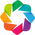

:Overlay
   .Values.Actual    :Scatter   [x]   (y)
   .Values.Predicted :Scatter   [x]   (y)

In [12]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Convert y_test and predictions to a Holoviews Scatter element
actual_values = hv.Scatter((y_test, y_test), label='Actual', group='Values').opts(color='blue', marker='o', size=5)
predicted_values = hv.Scatter((y_test, svr_pred.flatten()), label='Predicted', group='Values').opts(color='red', marker='x', size=5)

# Overlay the Scatter plots and define plot options
scatter_plot = (actual_values * predicted_values).opts(
    opts.Scatter(width=800, height=600, legend_position='top_left', xlabel='Actual Values', ylabel='Predicted Values')
)

scatter_plot


In [13]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_scaled, y_train)

rf_scores = cross_val_score(rf_regressor, X_train_scaled, y_train, cv=5)  # Perform 5-fold cross-validation

rf_regressor_pred = rf_regressor.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, rf_regressor_pred)

print("Random Forest Scores:", rf_scores)
print("Mean Random Forest Score:", rf_scores.mean())
print(f'Mean Squared Error:{mse_rf}')

Random Forest Scores: [0.99970066 0.998392   0.99281585 0.99958782 0.99681832]
Mean Random Forest Score: 0.9974629302890566
Mean Squared Error:1.254440020904454e-07


In [14]:
optimal_structure_index_rf = np.argmax(rf_regressor_pred)
optimal_structure_rf = structures_df.iloc[optimal_structure_index_rf]

freq_value_rf = optimal_structure_rf['frequency']
epsilon_values_rf = optimal_structure_rf['epsilon']
mu_values_rf = optimal_structure_rf['mu']
optimal_materials_rf = optimal_structure_rf['materials']
ref_coeff_rf = optimal_structure_rf['reflection_coeff']
trans_coeff_rf = optimal_structure_rf['transmission_coeff']
thickness_vals_rf = optimal_structure_rf['thickness']
emi_se_rf = optimal_structure_rf['shielding_effectiveness']
absorption_rf = optimal_structure_rf['absorption']


# Print results
print("Optimal 5-Layered Structure (Random Forest Model):")
print("Incident frequency:", freq_value_rf)
print("Epsilon values:", epsilon_values_rf)
print("Mu values:", mu_values_rf)
print("Material IDs:", optimal_materials_rf)
print("Thickness values:", thickness_vals_rf)
print("Reflection Coefficient:", ref_coeff_rf)
print("Transmission Coefficient:", trans_coeff_rf)
print("EMI Shielding Effectiveness:", emi_se_rf)
print("Absorption:", absorption_rf)

Optimal 5-Layered Structure (Random Forest Model):
Incident frequency: 12000000000.0
Epsilon values: [(234.7425-311.4114j), (3.1563-0.3053j), (234.7425-311.4114j), (3.1563-0.3053j), (32.2393-47.5891j)]
Mu values: [(1+0j), (0.9768-0.09j), (1+0j), (0.9768-0.09j), (1+0j)]
Material IDs: [1 3 1 3 2]
Thickness values: [0.00285 0.0027  0.00255 0.00195 0.001  ]
Reflection Coefficient: 9.626343201651139e-12
Transmission Coefficient: 3.7326781045166693e-13
EMI Shielding Effectiveness: 124.27979460772825
Absorption: 0.9999999999900004


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
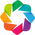

:Overlay
   .Values.Actual    :Scatter   [x]   (y)
   .Values.Predicted :Scatter   [x]   (y)

In [15]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Convert y_test and predictions to a Holoviews Scatter element
actual_values = hv.Scatter((y_test, y_test), label='Actual', group='Values').opts(color='blue', marker='o', size=5)
predicted_values = hv.Scatter((y_test, rf_regressor_pred.flatten()), label='Predicted', group='Values').opts(color='red', marker='x', size=5)

# Overlay the Scatter plots and define plot options
scatter_plot = (actual_values * predicted_values).opts(
    opts.Scatter(width=800, height=600, legend_position='top_left', xlabel='Actual Values', ylabel='Predicted Values')
)

scatter_plot


In [ ]:
predicted_structures_df.to_csv('structures_for_multiple_frequencies.csv', encoding='utf-8')

In [ ]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train_scaled, y_train)

xgb_scores = cross_val_score(xgb_regressor, X_train_scaled, y_train, cv=5)  # Perform 5-fold cross-validation

xgb_regressor_pred = xgb_regressor.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, xgb_regressor_pred)

print(f'Mean Squared Error:{mse_xgb}')
print("XGBoost Scores:", xgb_scores)
print("Mean XGBoost Score:", xgb_scores.mean())

In [ ]:
optimal_structure_index_xgb = np.argmax(xgb_regressor_pred)
optimal_structure_xgb = structures_df.iloc[optimal_structure_index_xgb]

freq_value_xgb = optimal_structure_xgb['frequency']
epsilon_values_xgb = optimal_structure_xgb['epsilon']
mu_values_xgb = optimal_structure_xgb['mu']
optimal_materials_xgb = optimal_structure_xgb['materials']
thickness_values_xgb = optimal_structure_xgb['thickness']
ref_coeff_xgb = optimal_structure_xgb['reflection_coeff']
trans_coeff_xgb = optimal_structure_xgb['transmission_coeff']
emi_se_xgb = optimal_structure_xgb['shielding_effectiveness']
absorption_xgb = optimal_structure_xgb['absorption']


# Print results
print("Optimal 5-Layered Structure (XGBoost Model):")
print("Incident frequency:", freq_value_xgb)
print("Epsilon values:", epsilon_values_xgb)
print("Mu values:", mu_values_xgb)
print("Material IDs:", optimal_materials_xgb)
print("Thickness Values:", thickness_values_xgb)
print("Reflection Coefficient:", ref_coeff_xgb)
print("Transmission Coefficient:", trans_coeff_xgb)
print("EMI Shielding Effectiveness:", emi_se_xgb)
print("Absorption:", absorption_xgb)

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Convert y_test and predictions to a Holoviews Scatter element
actual_values = hv.Scatter((y_test, y_test), label='Actual', group='Values').opts(color='blue', marker='o', size=5)
predicted_values = hv.Scatter((y_test, xgb_regressor_pred.flatten()), label='Predicted', group='Values').opts(color='red', marker='x', size=5)

# Overlay the Scatter plots and define plot options
scatter_plot = (actual_values * predicted_values).opts(
    opts.Scatter(width=800, height=600, legend_position='top_left', xlabel='Actual Values', ylabel='Predicted Values')
)

scatter_plot


In [ ]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train_scaled, y_train)

dt_pred = dt_regressor.predict(X_test_scaled)
dt_scores = cross_val_score(dt_regressor, X_train_scaled, y_train, cv=5)  # Perform 5-fold cross-validation

mse_dt = mean_squared_error(y_test, dt_pred)

print(f'Mean Squared Error:{mse_dt}')
print("Decision Tree Scores:", dt_scores)
print("Mean Decision Tree Score:", dt_scores.mean())

In [ ]:
optimal_structure_index_dt = np.argmax(dt_pred)
optimal_structure_dt = structures_df.iloc[optimal_structure_index_dt]

freq_value_dt = optimal_structure_dt['frequency']
epsilon_values_dt = optimal_structure_dt['epsilon']
mu_values_dt = optimal_structure_dt['mu']
optimal_materials_dt = optimal_structure_dt['materials']
thickness_values_dt = optimal_structure_dt['thickness']
ref_coeff_dt = optimal_structure_dt['reflection_coeff']
trans_coeff_dt = optimal_structure_dt['transmission_coeff']
emi_se_dt = optimal_structure_dt['shielding_effectiveness']
absorption_dt = optimal_structure_dt['absorption']


# Print results
print("Optimal 5-Layered Structure (Decision Tree Model):")
print("Incident frequency:", freq_value_dt)
print("Epsilon values:", epsilon_values_dt)
print("Mu values:", mu_values_dt)
print("Material IDs:", optimal_materials_dt)
print("Thickness values:", thickness_values_dt)
print("Reflection Coefficient:", ref_coeff_dt)
print("Transmission Coefficient:", trans_coeff_dt)
print("EMI Shielding Effectiveness:", emi_se_dt)
print("Absorption:", absorption_dt)

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Convert y_test and predictions to a Holoviews Scatter element
actual_values = hv.Scatter((y_test, y_test), label='Actual', group='Values').opts(color='blue', marker='o', size=5)
predicted_values = hv.Scatter((y_test, dt_pred.flatten()), label='Predicted', group='Values').opts(color='red', marker='x', size=5)

# Overlay the Scatter plots and define plot options
scatter_plot = (actual_values * predicted_values).opts(
    opts.Scatter(width=800, height=600, legend_position='top_left', xlabel='Actual Values', ylabel='Predicted Values')
)

scatter_plot


In [ ]:
import matplotlib.pyplot as plt

# Assuming svr_scores, xgb_scores, dt_scores, and rf_scores are lists of scores
models = ['SVR', 'XGBoost', 'Decision Tree', 'Random Forest']
scores = [svr_scores, xgb_scores, dt_scores, rf_scores]

plt.figure(figsize=(10, 6))

for model, score in zip(models, scores):
    plt.plot(score, label=model, alpha=0.5)

plt.xlabel('Cross Validation Fold')
plt.ylabel('Score')
plt.title('Cross Validation Scores of Regression Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
structures_df.describe()

In [ ]:
from matplotlib import pyplot as plt
structures_df.plot(kind='scatter', x='transmission_coeff', y='shielding_effectiveness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = structures_df[['reflection_coeff', 'transmission_coeff','shielding_effectiveness','absorption']]
y = structures_df['absorption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Build neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

# Evaluate model
loss = model.evaluate(X_test_scaled, y_test)

# Print loss
print("Test Loss:", loss)

# Print hyperparameters
print("Neural Network Hyperparameters:")
print("Number of hidden layers:", len(model.layers) - 1)  # Exclude input layer
print("Number of neurons per hidden layer:", [layer.units for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)])


In [ ]:
import keras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the neural network model function
def create_model(num_hidden_layers, num_neurons_per_layer):
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons_per_layer[0], input_dim=X_train.shape[1], activation='relu'))
    for _ in range(1, num_hidden_layers):
        model.add(keras.layers.Dense(num_neurons_per_layer[_], activation='relu'))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create a KerasRegressor based on your model function
model = KerasRegressor(model=create_model, num_hidden_layers=2, num_neurons_per_layer=[128, 64])

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam','rmsprop','sgd'],
    'num_hidden_layers': [2, 3, 4],  # Example values for the number of hidden layers
    'num_neurons_per_layer': [(128, 64), (64, 32),(256,128)],  # Example values for neurons per layer
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_result = grid.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
import matplotlib.pyplot as plt

# Get the mean test scores and hyperparameters from the grid search results
mean_test_scores = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

# Extract hyperparameter values
num_hidden_layers_values = [param['num_hidden_layers'] for param in params]
num_neurons_per_layer_values = [param['num_neurons_per_layer'] for param in params]

# Plot each hyperparameter combination separately
plt.figure(figsize=(10, 6))
for i in range(len(mean_test_scores)):
    plt.scatter(num_hidden_layers_values[i], mean_test_scores[i], label=f'{num_hidden_layers_values[i]}, {num_neurons_per_layer_values[i]}', alpha=0.5)

plt.xlabel('Number of Hidden Layers')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.legend(title='Number of Neurons per Layer', loc='best')
plt.show()


In [ ]:
# Create a new model with the best hyperparameters
best_model = create_model(num_hidden_layers=2, num_neurons_per_layer=(256, 128))

# Train the model on the entire training dataset
history = best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the testing dataset
test_loss = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Loss:", test_loss)


In [ ]:
# Use the trained model to make predictions on the testing dataset
predictions = best_model.predict(X_test_scaled)

# Print the predictions
print("Predictions:", predictions)

In [ ]:
print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", predictions.shape)

In [ ]:
predictions = np.ravel(predictions)

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Convert y_test and predictions to a Holoviews Scatter element
actual_values = hv.Scatter((y_test, y_test), label='Actual', group='Values').opts(color='blue', marker='o', size=5)
predicted_values = hv.Scatter((y_test, predictions.flatten()), label='Predicted', group='Values').opts(color='red', marker='x', size=5)

# Overlay the Scatter plots and define plot options
scatter_plot = (actual_values * predicted_values).opts(
    opts.Scatter(width=800, height=600, legend_position='top_left', xlabel='Actual Values', ylabel='Predicted Values')
)

scatter_plot


In [ ]:
std_dev = np.std(predictions - y_test)

# Print the standard deviation
print("Standard Deviation:", std_dev)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model architecture
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model using backpropagation
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", test_loss)
